# EP-LHb model

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline
from matplotlib import rcParams

# rcParams['figure.figsize'] = [20, 4]
# rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Define model and optimizers

In [3]:
class EPLHb(nn.Module):
  def __init__(self, EP_size, LHb_size, DAN_size, prob_EP_to_LHb: float=1, fixed_sign: bool=False, neg_output: bool=True):
    super(EPLHb,self).__init__()
    self.EP_to_LHb = nn.Linear(EP_size, LHb_size, bias=True)
    # nn.init.xavier_normal_(self.EP_to_LHb.weight)
    self.LHb_to_DAN = nn.Linear(LHb_size, DAN_size, bias=True)
    # nn.init.xavier_normal_(self.LHb_to_DAN.weight)

    self.EP_size = EP_size
    self.LHb_size = LHb_size
    self.DAN_size = DAN_size
    
    with torch.no_grad():
      # Make EP to LHb sparse
      n_zeros = int((1-prob_EP_to_LHb) * self.EP_to_LHb.weight.numel())
      sparse_idx = torch.randperm(self.EP_to_LHb.weight.numel())[:n_zeros]
      self.EP_to_LHb.weight.data.view(-1)[sparse_idx] = 0
      
      # Make LHb to DAN all negative
      self.neg_output = neg_output
      if neg_output: self.LHb_to_DAN.weight.data = -torch.sign(self.LHb_to_DAN.weight)*self.LHb_to_DAN.weight

      # Turn into fixed sign (obey Dale's law)
      self.fixed_sign = fixed_sign
      pos_neurons = {}
      neg_neurons = {}
      if fixed_sign:
        for name, param in self.named_parameters():
          if "weight" in name:
            # Find each neuron is excitatory or inhibitory
            pos_neurons[name] = torch.sum(param.data, axis=0) >= 0
            neg_neurons[name] = torch.sum(param.data, axis=0) < 0
            # Make all weights of that neuron excitatory or inhibitory
            param.data[:,pos_neurons[name]] = torch.sign(param[:,pos_neurons[name]])*param[:,pos_neurons[name]]
            param.data[:,neg_neurons[name]] = -torch.sign(param[:,neg_neurons[name]])*param[:,neg_neurons[name]]
    
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

    # Store original weights information
    self.sparse_idx = sparse_idx
    self.pos_neurons = pos_neurons
    self.neg_neurons = neg_neurons
    self.init_weights = self.record_params(calc_sign=False)

  def enforce_weights(self):
    with torch.no_grad():
      # Keep EP to LHb sparse
      self.EP_to_LHb.weight.data.view(-1)[self.sparse_idx] = 0
      # Make LHb to DAN all negative
      if self.neg_output:
        self.LHb_to_DAN.weight.data=torch.minimum(self.LHb_to_DAN.weight, 0*self.LHb_to_DAN.weight)

  def forward(self, input):
    LHB_act = self.EP_to_LHb(input)
    LHB_out = self.tanh(LHB_act)

    DAN_act = self.LHb_to_DAN(LHB_out)
    DAN_out = self.tanh(DAN_act)

    return DAN_out
  
  def record_params(self, calc_sign: bool=True):
    # Save the network weights
    recorded_params = {}
    for name, param in self.named_parameters():
        if param.requires_grad:
          with torch.no_grad():
            cur_data = param.data.detach().cpu().clone()
            recorded_params[name] = (cur_data)
          
          if calc_sign:
            print(name)
            frac_pos = 100*(torch.sum(cur_data > 0)/cur_data.numel()).numpy()
            frac_zero = 100*(torch.sum(cur_data == 0)/cur_data.numel()).numpy()
            frac_neg = 100*(torch.sum(cur_data < 0)/cur_data.numel()).numpy()
            print(' Positive: ' + str(frac_pos) + '%; Negative: ' + str(frac_neg) + '%; Zero: ' + str(frac_zero) + '%')
            
    return recorded_params
  
  def train_model(self,num_epochs,train_loader,optimizer,
                  loss: str='MSE',
                  print_epoch: bool=True):

    # Define loss function
    training_loss = []
    if loss == 'MSE': loss_function = nn.MSELoss()
    elif loss in 'CrossEntropyLoss': loss_function = nn.CrossEntropyLoss()
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    # Train the network
    for epoch in range(num_epochs):
      for i, (data,labels) in enumerate(train_loader):
        optimizer.zero_grad()

        if data.ndim != 2: data = data.view(-1,self.EP_size)
        outputs = self(data)

        loss = loss_function(outputs.squeeze(), labels) #maybe need to flatten outputs
        training_loss.append(loss.data.cpu())

        loss.backward()
        optimizer.step(init_weights=list(self.init_weights.values()))
        self.enforce_weights()
        
      if print_epoch:
        print('Epoch [%d/%d], Loss: %.4f'  %(epoch+1, num_epochs, loss.data))
      # scheduler.step()

    return training_loss

In [4]:
class NeuronalData(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_data = self.inputs[idx]
        label = self.labels[idx]
        return input_data, label

In [5]:
class gd(torch.optim.Optimizer): 
    def __init__(self, params, lr=0.01, fixed_sign: bool = False): 
        defaults = dict(lr=lr, fixed_sign=fixed_sign) 
        super(gd, self).__init__(params, defaults) 
  
    def step(self, init_weights=None): 
        for group in self.param_groups: 
            for i, p in enumerate(group['params']): 
                if p.grad is None: 
                    continue
                p.data = p.data - group['lr']*p.grad.data

                if group['fixed_sign']:
                    if init_weights is None: ValueError('Need to provide initial weights if fixed_sign is true!')
                    flip_mask = init_weights[i].sign()*p.data.sign()<0
                    p.data[flip_mask] = 0

In [6]:
class adam(torch.optim.Optimizer): 
	def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, fixed_sign: bool = False): 
		defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, fixed_sign=fixed_sign)
		super(adam, self).__init__(params, defaults) 

	def step(self, init_weights=None): 
		for group in self.param_groups: 
			for i, p in enumerate(group['params']): 
				if p.grad is None: 
					continue
				grad = p.grad.data 
				if grad.is_sparse: 
					raise RuntimeError("Adam does not support sparse gradients") 

				state = self.state[p] 

				# State initialization 
				if len(state) == 0: 
					state["step"] = 0
					# Momentum: Exponential moving average of gradient values 
					state["exp_avg"] = torch.zeros_like(p.data) 
					# RMS prop componenet: Exponential moving average of squared gradient values 
					state["exp_avg_sq"] = torch.zeros_like(p.data) 

				exp_avg, exp_avg_sq = state["exp_avg"], state["exp_avg_sq"] 
				beta1, beta2 = group["betas"] 
				state["step"] += 1

				if group['weight_decay'] != 0: 
					grad = grad.add(p.data, alpha=group['weight_decay']) 

				# Decay the first and second moment running average coefficient
				exp_avg.lerp_(grad, 1 - beta1) # momentum
				exp_avg_sq.mul_(beta2).addcmul_(grad, grad.conj(), value=1-beta2) # rms
			
				bias_correction1 = 1 - beta1 ** state["step"] 
				bias_correction2 = 1 - beta2 ** state["step"] 

				step_size = group["lr"] / bias_correction1
				bias_correction2_sqrt = math.sqrt(bias_correction2)

				denom = (exp_avg_sq.sqrt() / bias_correction2_sqrt).add_(group["eps"])

				p.data.addcdiv_(exp_avg, denom, value=-step_size)
				
				if group["fixed_sign"]: 
					if init_weights is None: ValueError('Need to provide initial weights if fixed_sign is true!')
					flip_mask = init_weights[i].sign()*p.data.sign()<0
					p.data[flip_mask] = 0

## Generate data

In [7]:
EP_size = 300 # there are this many inputs that represent features and set to -1, 0, 1
LHB_size = 100 # number of neurons in the LHB that receive EP input
DAN_size = 10 # how DANs to calculate value
batch_size = 200 # the size of input data took for one iteration
num_epochs = 200
num_relearn_epochs = 200
lr = 1e-2 # size of step

label_type = 'digital' # or 'digital'
prob_EP_to_LHb = 1

In [8]:
#@title Generate the data

prob_input_active = 0.05 # probability that an input is active in each context
prob_output_active = 0.125
n_contexts = 5000

rands = torch.rand(n_contexts, EP_size, device=device)
train_data = 1.0*(rands<prob_input_active) - 1.0*(rands>(1-prob_input_active))
rands = torch.rand(n_contexts, device=device)
if label_type == 'analog': train_labels = 2*rands-1
else: train_labels = 1.0*(rands<prob_output_active) - 1.0*(rands>(1-prob_output_active))
train_labels = torch.transpose(train_labels.repeat(DAN_size, 1).squeeze(), 0, 1)

rands = torch.rand(n_contexts, EP_size, device=device)
test_data = 1.0*(rands<prob_input_active) - 1.0*(rands>(1-prob_input_active))
rands = torch.rand(n_contexts, device=device)
if label_type == 'analog': test_labels = 2*rands-1
else: test_labels = 1.0*(rands<prob_output_active) - 1.0*(rands>(1-prob_output_active))
test_labels = torch.transpose(test_labels.repeat(DAN_size, 1).squeeze(), 0, 1)

In [9]:
# Packaged into dataset
train_dataset = NeuronalData(train_data,train_labels)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = NeuronalData(test_data,test_labels)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

Text(0.5, 1.0, 'Test labels')

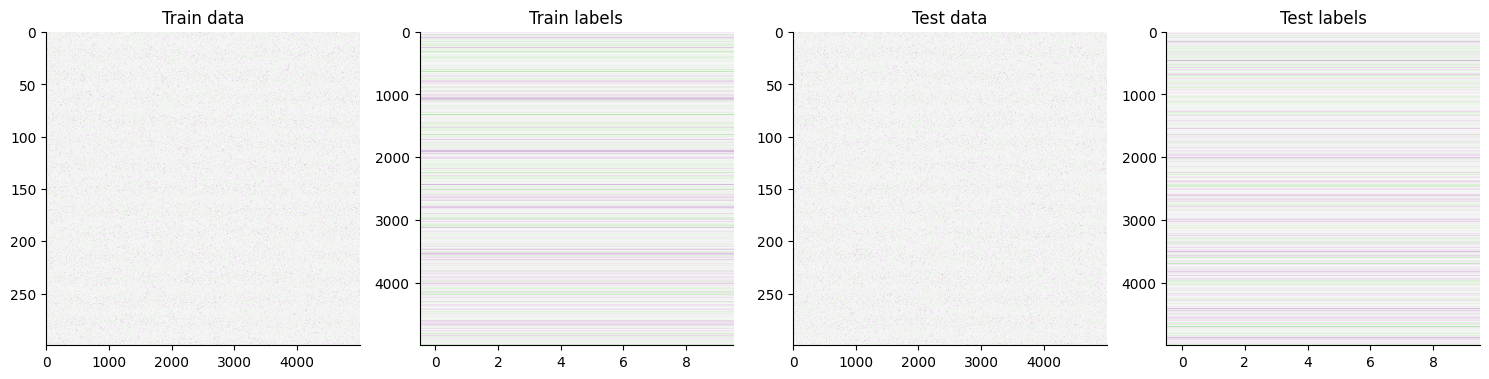

In [10]:
# Plot training data and label

fig, axs = plt.subplots(1,4, figsize=(15,5))

im = axs[0].imshow(torch.t(train_data), cmap='PRGn', aspect=train_data.shape[0]/train_data.shape[1])
axs[0].set_title('Train data')

if train_labels.ndim == 1: im = axs[1].imshow(train_labels[None], cmap='PRGn', aspect=train_labels.shape[0])
else: im = axs[1].imshow(train_labels, cmap='PRGn', aspect=train_labels.shape[1]/train_labels.shape[0])
axs[1].set_title('Train labels')

im = axs[2].imshow(torch.t(test_data), cmap='PRGn', aspect=test_data.shape[0]/test_data.shape[1])
axs[2].set_title('Test data')

if test_labels.ndim == 1: im = axs[3].imshow(test_labels[None], cmap='PRGn', aspect=test_labels.shape[0])
else: im = axs[3].imshow(test_labels, cmap='PRGn', aspect=test_labels.shape[1]/test_labels.shape[0])
axs[3].set_title('Test labels')

## Train co-release model

In [11]:
net = EPLHb(EP_size,LHB_size,DAN_size,prob_EP_to_LHb,fixed_sign=False)
if torch.cuda.is_available():
  net.cuda()

# Define loss-function & optimizer
loss_function = nn.MSELoss()
optimizer = adam(net.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
cr_training_loss = []

EP_to_LHb.weight
 Positive: 50.1800000667572%; Negative: 49.8199999332428%; Zero: 0.0%
EP_to_LHb.bias
 Positive: 49.000000953674316%; Negative: 50.999999046325684%; Zero: 0.0%
LHb_to_DAN.weight
 Positive: 0.0%; Negative: 100.0%; Zero: 0.0%
LHb_to_DAN.bias
 Positive: 69.9999988079071%; Negative: 30.000001192092896%; Zero: 0.0%


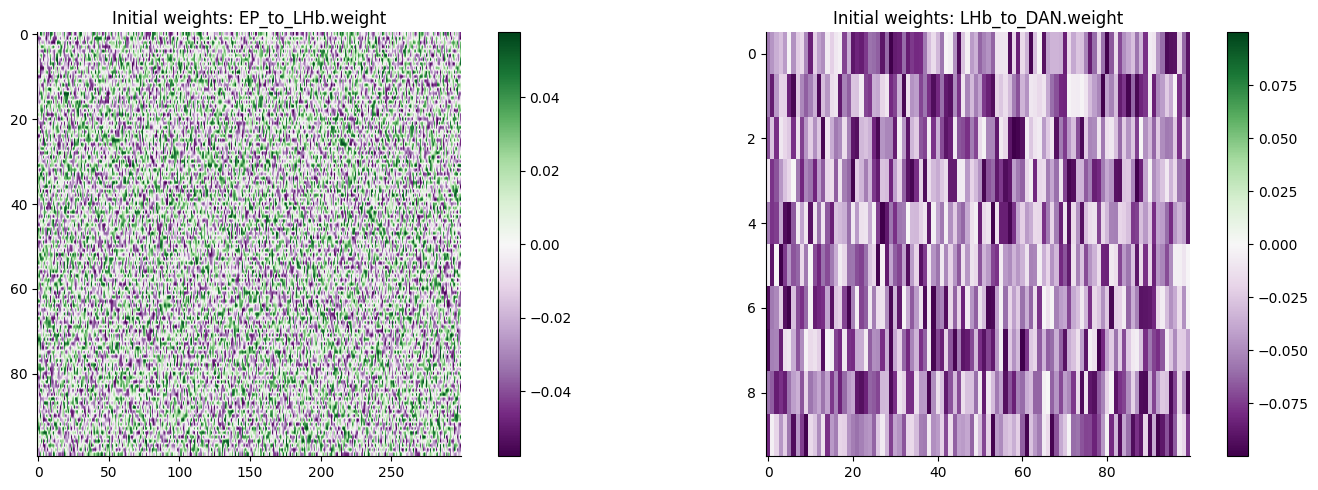

In [12]:
# Save the initial weights
initial_params_corelease = net.record_params()

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(initial_params_corelease)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in initial_params_corelease.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0],
                        vmax=abs(value.numpy()).max(), vmin=-abs(value.numpy()).max())
    axs[ax].set_title('Initial weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

Epoch [1/200], Loss: 0.2408
Epoch [2/200], Loss: 0.2364
Epoch [3/200], Loss: 0.2350
Epoch [4/200], Loss: 0.2497
Epoch [5/200], Loss: 0.2658
Epoch [6/200], Loss: 0.2018
Epoch [7/200], Loss: 0.3078
Epoch [8/200], Loss: 0.2203
Epoch [9/200], Loss: 0.2392
Epoch [10/200], Loss: 0.2447
Epoch [11/200], Loss: 0.2709
Epoch [12/200], Loss: 0.2130
Epoch [13/200], Loss: 0.1956
Epoch [14/200], Loss: 0.2247
Epoch [15/200], Loss: 0.2328
Epoch [16/200], Loss: 0.1931
Epoch [17/200], Loss: 0.1679
Epoch [18/200], Loss: 0.2202
Epoch [19/200], Loss: 0.1583
Epoch [20/200], Loss: 0.1163
Epoch [21/200], Loss: 0.1066
Epoch [22/200], Loss: 0.0905
Epoch [23/200], Loss: 0.0545
Epoch [24/200], Loss: 0.0509
Epoch [25/200], Loss: 0.0399
Epoch [26/200], Loss: 0.0344
Epoch [27/200], Loss: 0.0315
Epoch [28/200], Loss: 0.0341
Epoch [29/200], Loss: 0.0251
Epoch [30/200], Loss: 0.0221
Epoch [31/200], Loss: 0.0227
Epoch [32/200], Loss: 0.0177
Epoch [33/200], Loss: 0.0207
Epoch [34/200], Loss: 0.0223
Epoch [35/200], Loss: 0

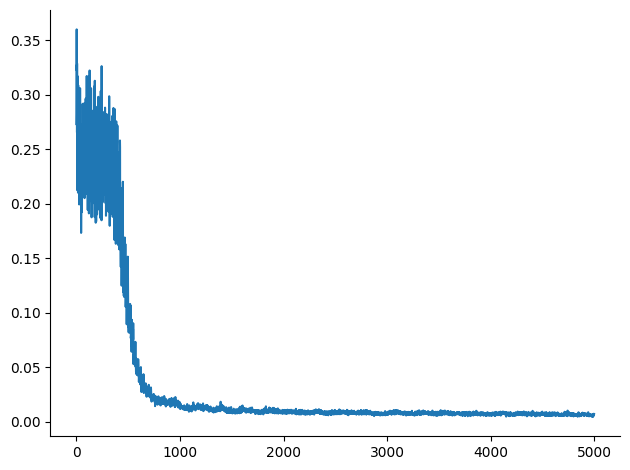

In [13]:
# Train the network
training_loss = net.train_model(num_epochs,train_loader,optimizer)
cr_training_loss.extend(training_loss)

# Plot training loss
plt.plot(cr_training_loss)

Text(0.5, 1.0, 'Accuracy: 0.6000 %')

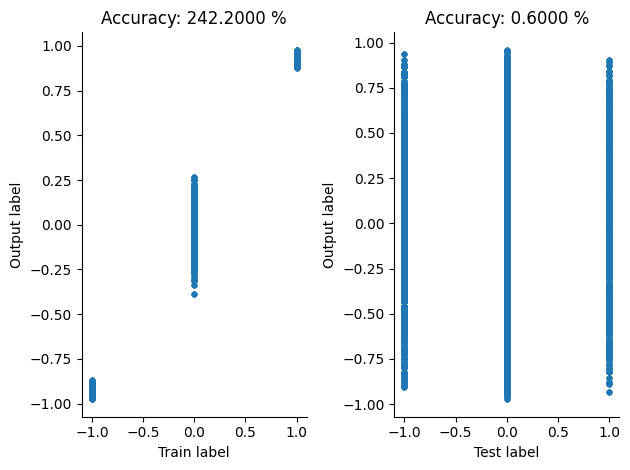

In [14]:
#@title Evaluating the accuracy of the model
with torch.no_grad():
  train_outputs = net(train_data)
  test_outputs = net(test_data)

  # Calculate accuracy
  train_accuracy = 100 * (torch.isclose(train_outputs.squeeze(), train_labels, rtol=1e-1)).sum() / train_labels.shape[0]
  test_accuracy = 100 * (torch.isclose(test_outputs.squeeze(), test_labels, rtol=1e-1)).sum() / test_labels.shape[0]

fig, axs = plt.subplots(1,2)

axs[0].scatter(train_labels.cpu().numpy(), train_outputs.cpu().numpy(), s=10,alpha=0.5)
axs[0].set_xlabel('Train label')
axs[0].set_ylabel('Output label')
axs[0].set_title('Accuracy: %.4f %%' %(train_accuracy))

axs[1].scatter(test_labels.cpu().numpy(), test_outputs.cpu().numpy(), s=10,alpha=0.5)
axs[1].set_xlabel('Test label')
axs[1].set_ylabel('Output label')
axs[1].set_title('Accuracy: %.4f %%' %(test_accuracy))

EP_to_LHb.weight
 Positive: 49.4133323431015%; Negative: 50.58666467666626%; Zero: 0.0%
EP_to_LHb.bias
 Positive: 50.999999046325684%; Negative: 49.000000953674316%; Zero: 0.0%
LHb_to_DAN.weight
 Positive: 0.0%; Negative: 79.00000214576721%; Zero: 20.999999344348907%
LHb_to_DAN.bias
 Positive: 100.0%; Negative: 0.0%; Zero: 0.0%


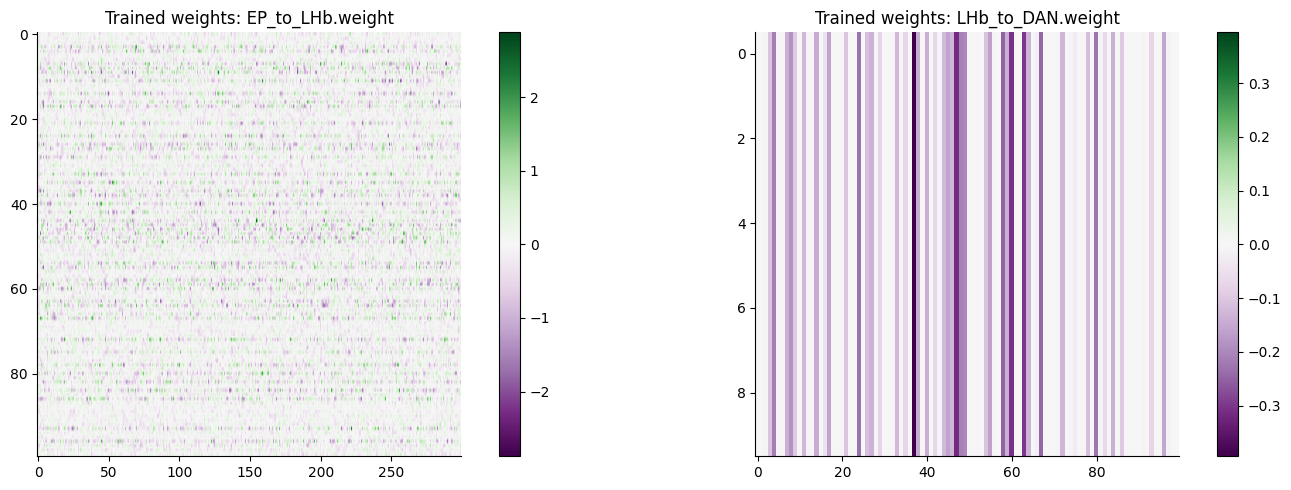

In [15]:
# Save the trianed parameters in paramList
trained_params_corelease = net.record_params()

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(trained_params_corelease)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in trained_params_corelease.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0],
                        vmax=abs(value.numpy()).max(), vmin=-abs(value.numpy()).max())
    axs[ax].set_title('Trained weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

EP_to_LHb.weight flipped:  45.373% (13612/30000)
EP_to_LHb.bias flipped:  52.000% (52/100)
LHb_to_DAN.weight flipped:  0.000% (0/1000)
LHb_to_DAN.bias flipped:  30.000% (3/10)
EP_to_LHb.weight changed:  100.000% (30000/30000)
EP_to_LHb.bias changed:  100.000% (100/100)
LHb_to_DAN.weight changed:  100.000% (1000/1000)
LHb_to_DAN.bias changed:  100.000% (10/10)


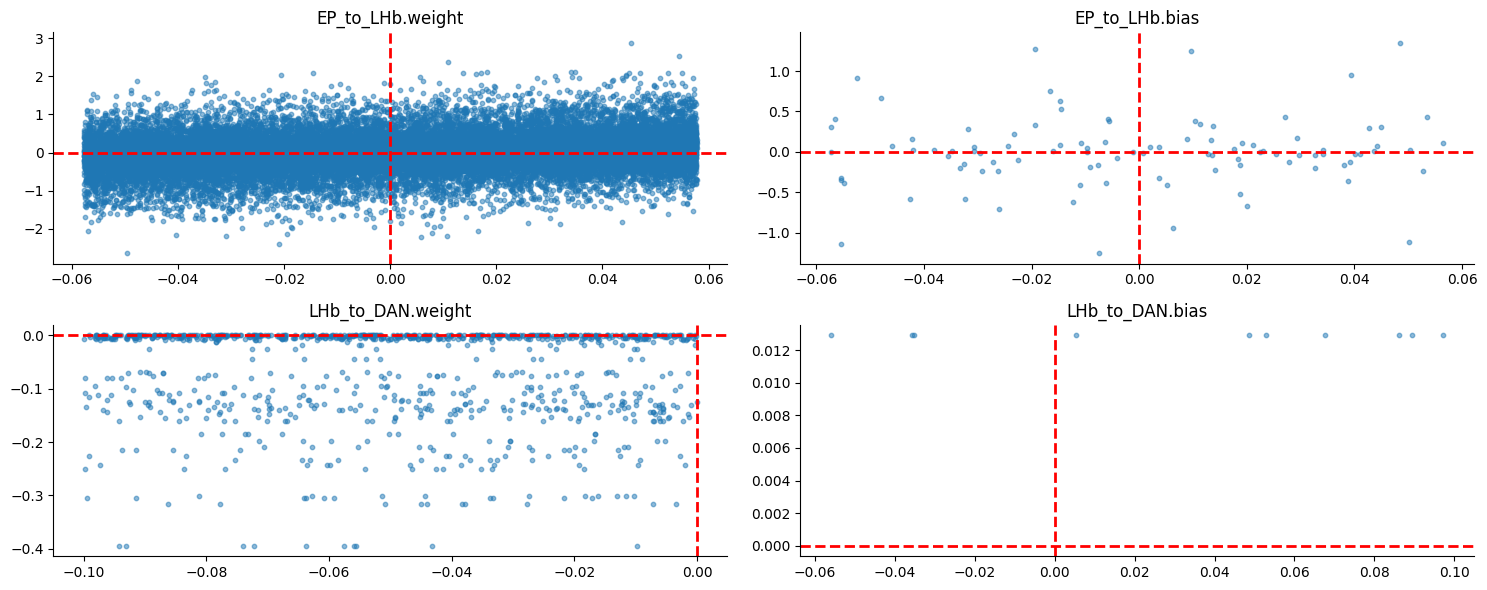

In [16]:
#@title What fraction of parameters flip sign?
for key in initial_params_corelease:
    n_weights=initial_params_corelease[key].numel()
    n_flip = (initial_params_corelease[key].sign()*trained_params_corelease[key].sign()<0).count_nonzero().item()
    print(key + ' flipped: % .3f%% (%d/%d)' %(100*n_flip/n_weights, n_flip, n_weights))

for key in initial_params_corelease:
    n_weights=initial_params_corelease[key].numel()
    n_changed = (initial_params_corelease[key] != trained_params_corelease[key]).count_nonzero().item()
    print(key + ' changed: % .3f%% (%d/%d)' %(100*n_changed/n_weights, n_changed, n_weights))

# Plot initial vs trained values

fig, axs = plt.subplots(2,int(len(trained_params_corelease)/2),figsize=(15, 6))
plt.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axs.flatten()):
    key = list(initial_params_corelease)[i]
    ax.scatter(initial_params_corelease[key].numpy(),trained_params_corelease[key].numpy(),s=10,alpha=0.5)
    ax.axhline(y=0, linewidth=2, color = 'r', ls='--')
    ax.axvline(x=0, linewidth=2, color = 'r', ls='--')
    ax.set_title(key)

plt.tight_layout()
plt.show()

## Train fixed sign model

In [17]:
fixed_sign_net = EPLHb(EP_size,LHB_size,DAN_size,prob_EP_to_LHb,fixed_sign=True)
if torch.cuda.is_available():
  fixed_sign_net.cuda()

# Define loss-function & optimizer
fs_loss_function = nn.MSELoss()
fs_optimizer = adam(fixed_sign_net.parameters(), lr=lr, fixed_sign=True)
# fs_scheduler = torch.optim.lr_scheduler.ExponentialLR(fs_optimizer, gamma=0.95)
fs_training_loss = []

EP_to_LHb.weight
 Positive: 50.999999046325684%; Negative: 49.000000953674316%; Zero: 0.0%
EP_to_LHb.bias
 Positive: 52.99999713897705%; Negative: 46.99999988079071%; Zero: 0.0%
LHb_to_DAN.weight
 Positive: 0.0%; Negative: 100.0%; Zero: 0.0%
LHb_to_DAN.bias
 Positive: 50.0%; Negative: 50.0%; Zero: 0.0%


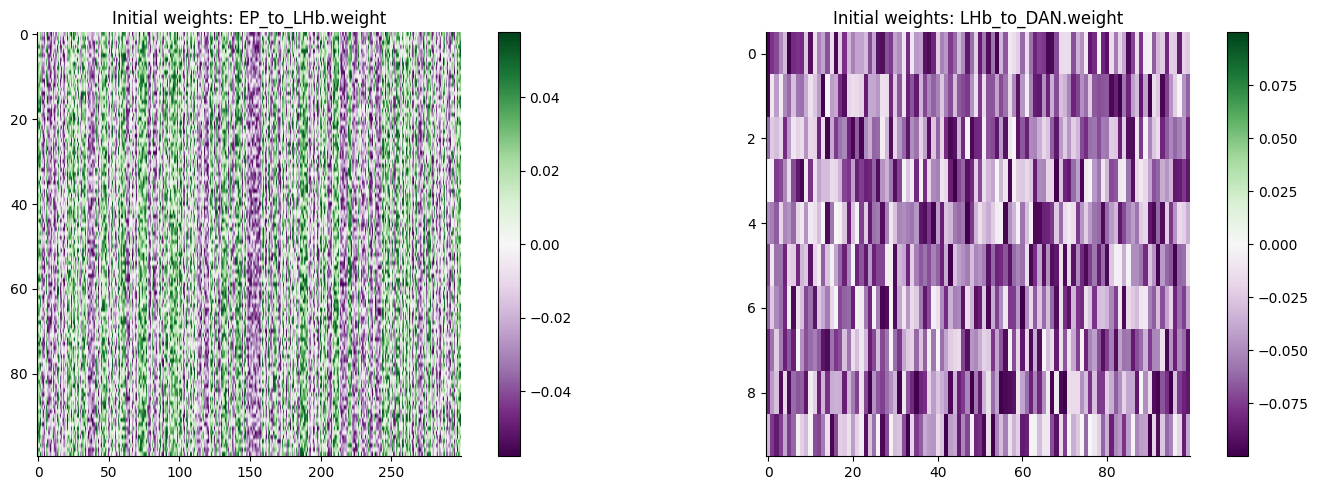

In [18]:
# Save the initial weights
initial_params_fixed = fixed_sign_net.record_params()

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(initial_params_fixed)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in initial_params_fixed.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0],
                        vmax=abs(value.numpy()).max(), vmin=-abs(value.numpy()).max())
    axs[ax].set_title('Initial weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

In [19]:
# Train the network
training_loss = fixed_sign_net.train_model(num_epochs,train_loader,fs_optimizer)
fs_training_loss.extend(training_loss)

Epoch [1/200], Loss: 0.2250
Epoch [2/200], Loss: 0.2878
Epoch [3/200], Loss: 0.2495
Epoch [4/200], Loss: 0.2283
Epoch [5/200], Loss: 0.2300
Epoch [6/200], Loss: 0.2475
Epoch [7/200], Loss: 0.2794
Epoch [8/200], Loss: 0.2969
Epoch [9/200], Loss: 0.2193
Epoch [10/200], Loss: 0.2897
Epoch [11/200], Loss: 0.2687
Epoch [12/200], Loss: 0.2834
Epoch [13/200], Loss: 0.2576
Epoch [14/200], Loss: 0.2509
Epoch [15/200], Loss: 0.2558
Epoch [16/200], Loss: 0.2682
Epoch [17/200], Loss: 0.2190
Epoch [18/200], Loss: 0.2088
Epoch [19/200], Loss: 0.2331
Epoch [20/200], Loss: 0.2457
Epoch [21/200], Loss: 0.2584
Epoch [22/200], Loss: 0.2517
Epoch [23/200], Loss: 0.2183
Epoch [24/200], Loss: 0.2550
Epoch [25/200], Loss: 0.2283
Epoch [26/200], Loss: 0.2691
Epoch [27/200], Loss: 0.2112
Epoch [28/200], Loss: 0.2365
Epoch [29/200], Loss: 0.2368
Epoch [30/200], Loss: 0.2406
Epoch [31/200], Loss: 0.2690
Epoch [32/200], Loss: 0.2645
Epoch [33/200], Loss: 0.2930
Epoch [34/200], Loss: 0.2688
Epoch [35/200], Loss: 0

Text(0, 0.5, 'Loss')

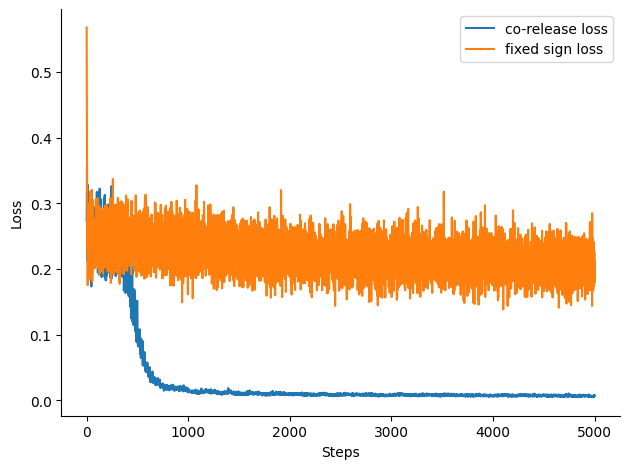

In [20]:
# Plot training loss
plt.plot(cr_training_loss, label='co-release loss')
plt.plot(fs_training_loss, label='fixed sign loss')

plt.legend()
plt.xlabel('Steps')
plt.ylabel('Loss')

Text(0.5, 1.0, 'Accuracy: 0.0000 %')

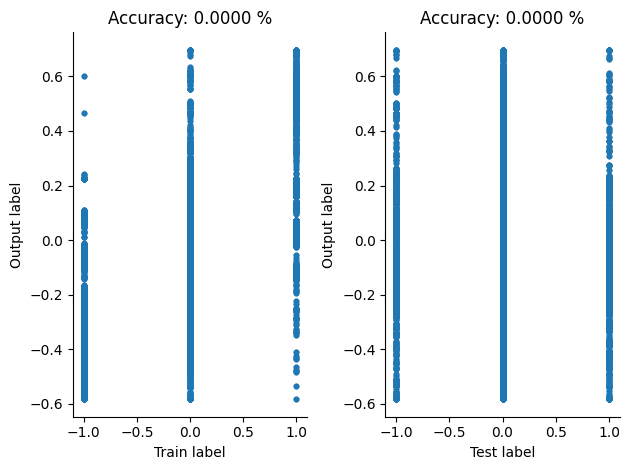

In [21]:
#@title Evaluating the accuracy of the model
with torch.no_grad():
  train_outputs = fixed_sign_net(train_data)
  test_outputs = fixed_sign_net(test_data)

  # Calculate accuracy
  train_accuracy = 100 * (torch.isclose(train_outputs.squeeze(), train_labels, rtol=1e-1)).sum() / train_labels.shape[0]
  test_accuracy = 100 * (torch.isclose(test_outputs.squeeze(), test_labels, rtol=1e-1)).sum() / test_labels.shape[0]

fig, axs = plt.subplots(1,2)

axs[0].scatter(train_labels.flatten().cpu().numpy(), train_outputs.flatten().cpu().numpy(), s=10,alpha=0.5)
axs[0].set_xlabel('Train label')
axs[0].set_ylabel('Output label')
axs[0].set_title('Accuracy: %.4f %%' %(train_accuracy))

axs[1].scatter(test_labels.flatten().cpu().numpy(), test_outputs.flatten().cpu().numpy(), s=10,alpha=0.5)
axs[1].set_xlabel('Test label')
axs[1].set_ylabel('Output label')
axs[1].set_title('Accuracy: %.4f %%' %(test_accuracy))

EP_to_LHb.weight
 Positive: 37.96333372592926%; Negative: 35.44999957084656%; Zero: 26.586666703224182%
EP_to_LHb.bias
 Positive: 43.99999976158142%; Negative: 43.99999976158142%; Zero: 11.999999731779099%
LHb_to_DAN.weight
 Positive: 0.0%; Negative: 5.000000074505806%; Zero: 94.9999988079071%
LHb_to_DAN.bias
 Positive: 50.0%; Negative: 0.0%; Zero: 50.0%


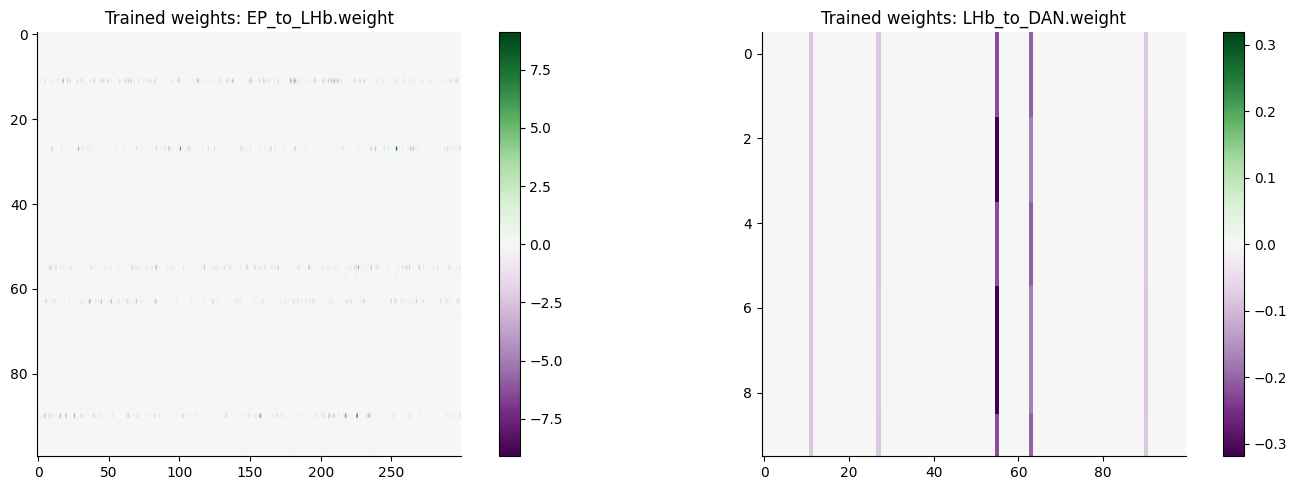

In [22]:
# Save the trianed parameters in paramList
trained_params_fixed = fixed_sign_net.record_params()

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(initial_params_fixed)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in trained_params_fixed.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0],
                        vmax=abs(value.numpy()).max(), vmin=-abs(value.numpy()).max())
    axs[ax].set_title('Trained weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

EP_to_LHb.weight flipped:  0.000% (0/30000)
EP_to_LHb.bias flipped:  0.000% (0/100)
LHb_to_DAN.weight flipped:  0.000% (0/1000)
LHb_to_DAN.bias flipped:  0.000% (0/10)
EP_to_LHb.weight changed:  100.000% (30000/30000)
EP_to_LHb.bias changed:  100.000% (100/100)
LHb_to_DAN.weight changed:  100.000% (1000/1000)
LHb_to_DAN.bias changed:  100.000% (10/10)


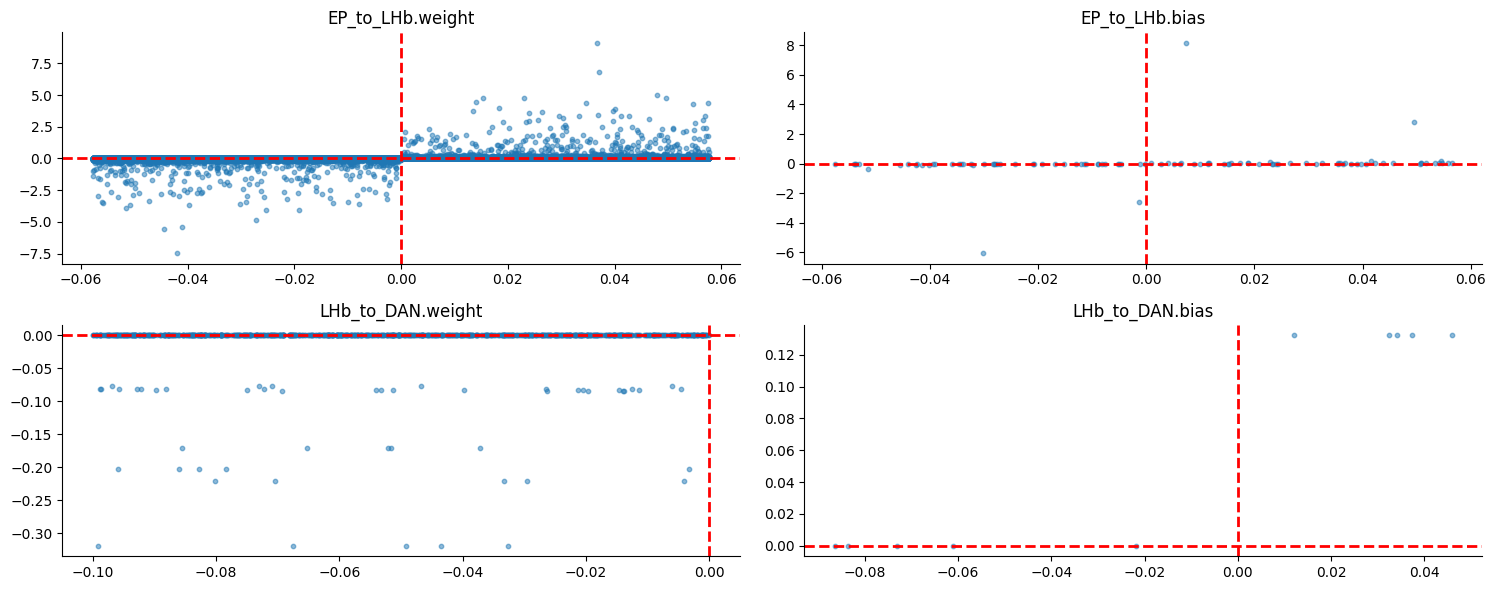

In [23]:
#@title What fraction of parameters flip sign?
for key in initial_params_fixed:
    n_weights=initial_params_fixed[key].numel()
    n_flip = (initial_params_fixed[key].sign()*trained_params_fixed[key].sign()<0).count_nonzero().item()
    print(key + ' flipped: % .3f%% (%d/%d)' %(100*n_flip/n_weights, n_flip, n_weights))

for key in initial_params_fixed:
    n_weights=initial_params_fixed[key].numel()
    n_changed = (initial_params_fixed[key] != trained_params_fixed[key]).count_nonzero().item()
    print(key + ' changed: % .3f%% (%d/%d)' %(100*n_changed/n_weights, n_changed, n_weights))

# Plot initial vs trained values

fig, axs = plt.subplots(2,int(len(trained_params_fixed)/2),figsize=(15, 6))
plt.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axs.flatten()):
    key = list(initial_params_fixed)[i]
    ax.scatter(initial_params_fixed[key].numpy(),trained_params_fixed[key].numpy(),s=10,alpha=0.5)
    ax.axhline(y=0, linewidth=2, color = 'r', ls='--')
    ax.axvline(x=0, linewidth=2, color = 'r', ls='--')
    ax.set_title(key)

plt.tight_layout()
plt.show()

## Flip some weights and relearn

In [24]:
#Generate the data by randomly flipping outputs

# prob_output_flip = 0.5

# nonzero_idx = train_labels.nonzero()
# flip_mask_nonzero = torch.rand(nonzero_idx.shape[0], device=device) < prob_output_flip
# flip_idx = nonzero_idx[flip_mask_nonzero].squeeze()
# train_labels_flipped = train_labels.clone()
# train_labels_flipped[flip_idx] *= -1

# n_flip = (train_labels.sign()*train_labels_flipped.sign()<0).count_nonzero().item()
# print('Flipped percentage: ' + str(100*n_flip/train_labels.shape[0]) + '%')

In [25]:
# Randomly select inputs, and flip corresponding labels
prob_EP_flip = 0.02

input_mask = torch.rand(EP_size,device=device) < prob_EP_flip
flip_EP = torch.linspace(1,EP_size,EP_size)[input_mask].to(torch.int32)
flip_idx = train_data.nonzero()[torch.isin(train_data.nonzero()[:,1], flip_EP),0].unique()

train_labels_flipped = train_labels.clone()
train_labels_flipped[flip_idx] *= -1

n_flip = (train_labels.sign()*train_labels_flipped.sign()<0).count_nonzero().item()
print('Flipped percentage: %.3f%%, %d/%d' % (100*n_flip/train_labels.shape[0], n_flip, n_contexts))
print('Flipped EP neurons: ' + str(flip_EP.numpy()))

flip_dataset = NeuronalData(train_data,train_labels_flipped)
flip_loader = DataLoader(dataset=flip_dataset, batch_size=batch_size, shuffle=True)

Flipped percentage: 100.000%, 5000/5000
Flipped EP neurons: [ 93 151 174 290 296]


In [28]:
train_labels_flipped[flip_idx].shape

torch.Size([2007, 10])

Text(0.5, 1.0, 'Flipped labels')

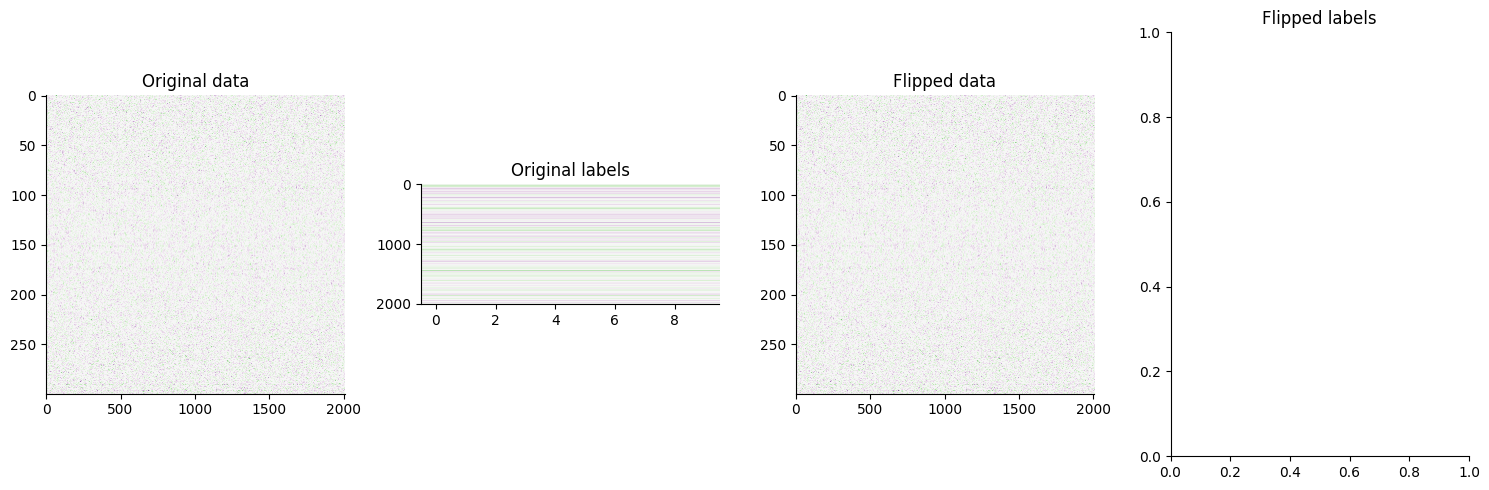

In [29]:
# Plot training data and label
fig, axs = plt.subplots(1,4, figsize=(15,5))

im = axs[0].imshow(torch.t(train_data[flip_idx]), cmap='PRGn', aspect=train_data[flip_idx].shape[0]/train_data[flip_idx].shape[1])
axs[0].set_title('Original data')

if train_labels.ndim == 1: im = axs[1].imshow(train_labels[flip_idx][None], cmap='PRGn', aspect=train_labels.shape[0])
else: im = axs[1].imshow(train_labels[flip_idx], cmap='PRGn', aspect=train_labels.shape[1]/train_labels.shape[0])
axs[1].set_title('Original labels')

im = axs[2].imshow(torch.t(train_data[flip_idx]), cmap='PRGn', aspect=train_data[flip_idx].shape[0]/train_data[flip_idx].shape[1])
axs[2].set_title('Flipped data')

if train_labels.ndim == 1: im = axs[1].imshow(train_labels_flipped[flip_idx][None], cmap='PRGn', aspect=train_labels.shape[0])
else: im = axs[1].imshow(train_labels_flipped[flip_idx], cmap='PRGn', aspect=train_labels.shape[1]/train_labels.shape[0])
axs[3].set_title('Flipped labels')

In [30]:
# Train the network
optimizer = adam(net.parameters(), lr=lr, fixed_sign=False)
training_loss = net.train_model(num_epochs,flip_loader,optimizer)
cr_training_loss.extend(training_loss)

fs_optimizer = adam(fixed_sign_net.parameters(), lr=lr, fixed_sign=True)
training_loss = fixed_sign_net.train_model(num_epochs,flip_loader,fs_optimizer)
fs_training_loss.extend(training_loss)

Epoch [1/200], Loss: 0.2274
Epoch [2/200], Loss: 0.2230
Epoch [3/200], Loss: 0.2342
Epoch [4/200], Loss: 0.1755
Epoch [5/200], Loss: 0.1375
Epoch [6/200], Loss: 0.1021
Epoch [7/200], Loss: 0.0724
Epoch [8/200], Loss: 0.0498
Epoch [9/200], Loss: 0.0343
Epoch [10/200], Loss: 0.0259
Epoch [11/200], Loss: 0.0272
Epoch [12/200], Loss: 0.0277
Epoch [13/200], Loss: 0.0166
Epoch [14/200], Loss: 0.0163
Epoch [15/200], Loss: 0.0194
Epoch [16/200], Loss: 0.0185
Epoch [17/200], Loss: 0.0159
Epoch [18/200], Loss: 0.0172
Epoch [19/200], Loss: 0.0150
Epoch [20/200], Loss: 0.0151
Epoch [21/200], Loss: 0.0134
Epoch [22/200], Loss: 0.0114
Epoch [23/200], Loss: 0.0148
Epoch [24/200], Loss: 0.0171
Epoch [25/200], Loss: 0.0145
Epoch [26/200], Loss: 0.0134
Epoch [27/200], Loss: 0.0152
Epoch [28/200], Loss: 0.0123
Epoch [29/200], Loss: 0.0139
Epoch [30/200], Loss: 0.0156
Epoch [31/200], Loss: 0.0125
Epoch [32/200], Loss: 0.0137
Epoch [33/200], Loss: 0.0130
Epoch [34/200], Loss: 0.0140
Epoch [35/200], Loss: 0

Text(0, 0.5, 'Loss')

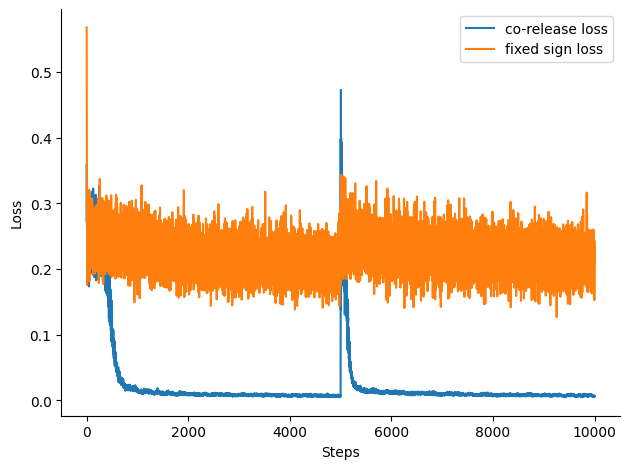

In [31]:
# Plot training loss
plt.plot(cr_training_loss, label='co-release loss')
plt.plot(fs_training_loss, label='fixed sign loss')

plt.legend()
plt.xlabel('Steps')
plt.ylabel('Loss')

## Relearn weights for co-release model

Text(0.5, 1.0, 'Accuracy: 95.2000 %')

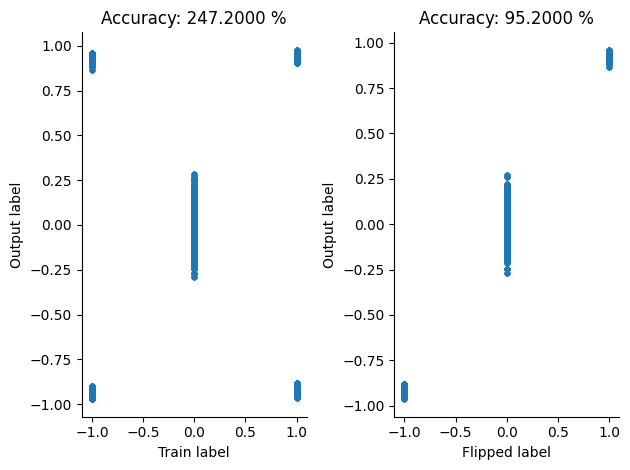

In [32]:
#@title Evaluating the accuracy of the model
with torch.no_grad():
  train_outputs = net(train_data)
  flipped_outputs = net(train_data[flip_idx,:])

  # Calculate accuracy
  train_accuracy = 100 * (torch.isclose(train_outputs.squeeze(), train_labels_flipped, rtol=1e-1)).sum() / train_labels.shape[0]
  flipped_accuracy = 100 * (torch.isclose(flipped_outputs.squeeze(), train_labels_flipped[flip_idx], rtol=1e-1)).sum() / test_labels.shape[0]

fig, axs = plt.subplots(1,2)

axs[0].scatter(train_labels.flatten().cpu().numpy(), train_outputs.flatten().cpu().numpy(), s=10,alpha=0.5)
axs[0].set_xlabel('Train label')
axs[0].set_ylabel('Output label')
axs[0].set_title('Accuracy: %.4f %%' %(train_accuracy))

axs[1].scatter(train_labels_flipped[flip_idx].flatten().cpu().numpy(), flipped_outputs.flatten().cpu().numpy(), s=10,alpha=0.5)
axs[1].set_xlabel('Flipped label')
axs[1].set_ylabel('Output label')
axs[1].set_title('Accuracy: %.4f %%' %(flipped_accuracy))

EP_to_LHb.weight
 Positive: 49.63666796684265%; Negative: 50.36333203315735%; Zero: 0.0%
EP_to_LHb.bias
 Positive: 49.000000953674316%; Negative: 50.999999046325684%; Zero: 0.0%
LHb_to_DAN.weight
 Positive: 0.0%; Negative: 100.0%; Zero: 0.0%
LHb_to_DAN.bias
 Positive: 100.0%; Negative: 0.0%; Zero: 0.0%


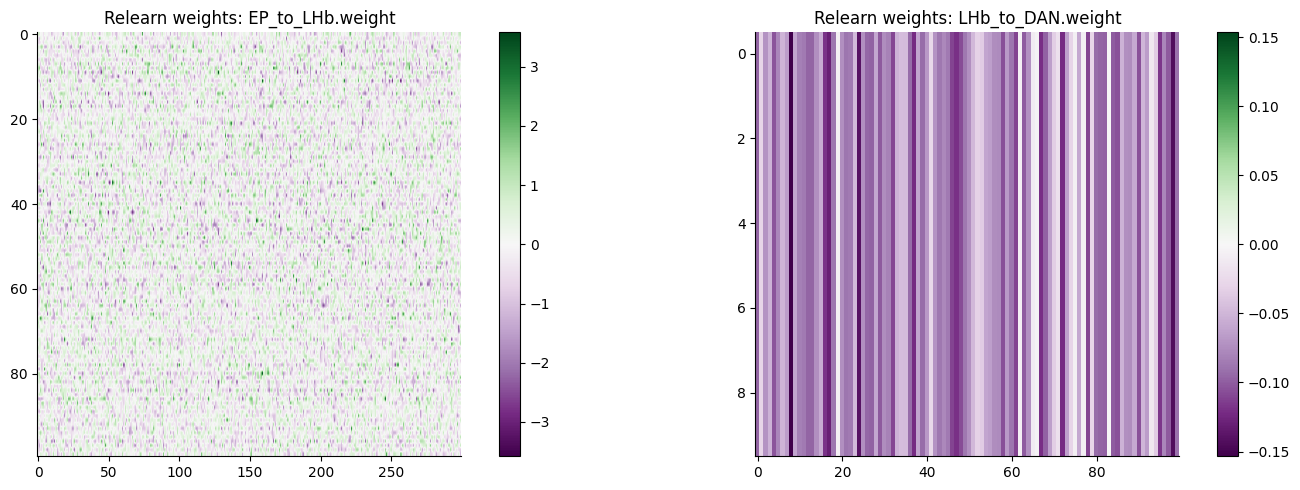

In [33]:
# Save the trianed parameters in paramList
relearn_params_corelease = net.record_params()

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(initial_params_corelease)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in relearn_params_corelease.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0],
                        vmax=abs(value.numpy()).max(), vmin=-abs(value.numpy()).max())
    axs[ax].set_title('Relearn weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

EP_to_LHb.weight flipped:  21.763% (6529/30000)
EP_to_LHb.bias flipped:  22.000% (22/100)
LHb_to_DAN.weight flipped:  0.000% (0/1000)
LHb_to_DAN.bias flipped:  0.000% (0/10)
EP_to_LHb.weight changed:  100.000% (30000/30000)
EP_to_LHb.bias changed:  100.000% (100/100)
LHb_to_DAN.weight changed:  100.000% (1000/1000)
LHb_to_DAN.bias changed:  100.000% (10/10)


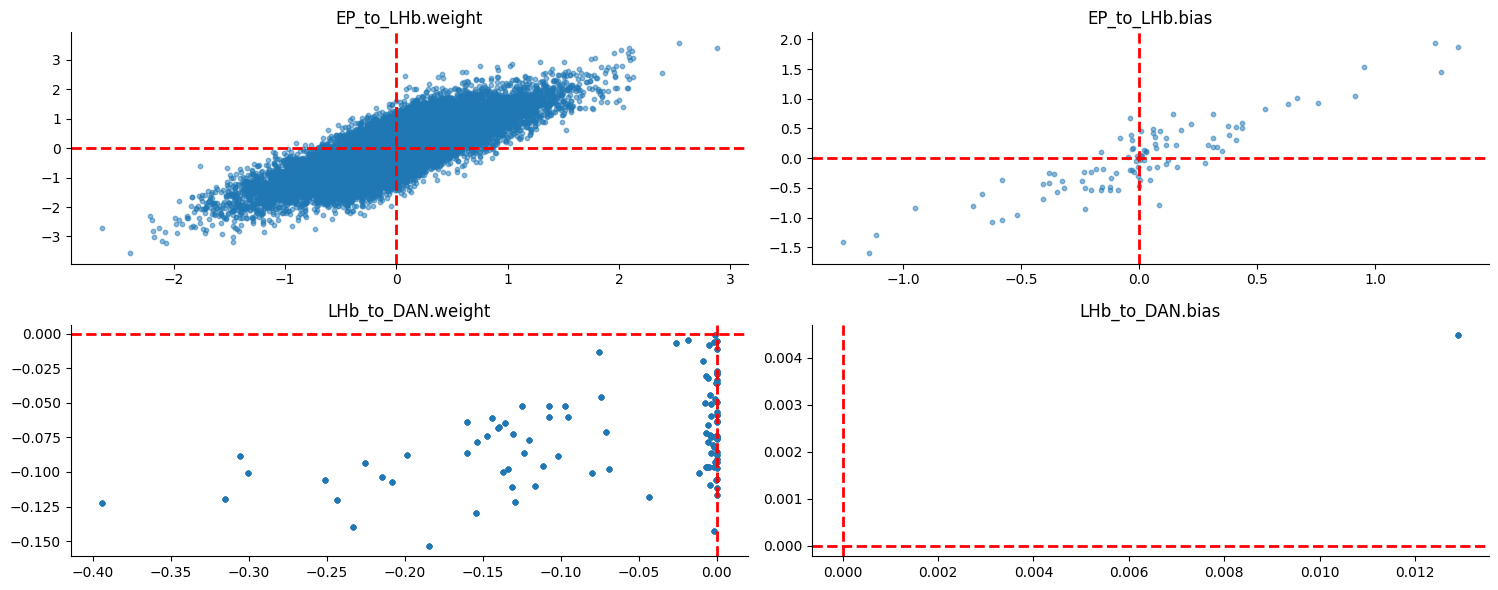

In [34]:
#@title What fraction of parameters flip sign?
for key in trained_params_corelease:
    n_weights=trained_params_corelease[key].numel()
    n_flip = (trained_params_corelease[key].sign()*relearn_params_corelease[key].sign()<0).count_nonzero().item()
    print(key + ' flipped: % .3f%% (%d/%d)' %(100*n_flip/n_weights, n_flip, n_weights))

for key in trained_params_corelease:
    n_weights=trained_params_corelease[key].numel()
    n_changed = (trained_params_corelease[key] != relearn_params_corelease[key]).count_nonzero().item()
    print(key + ' changed: % .3f%% (%d/%d)' %(100*n_changed/n_weights, n_changed, n_weights))

# Plot initial vs trained values
fig, axs = plt.subplots(2,int(len(relearn_params_corelease)/2),figsize=(15, 6))
plt.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axs.flatten()):
    key = list(relearn_params_corelease)[i]
    ax.scatter(trained_params_corelease[key].numpy(),relearn_params_corelease[key].numpy(),s=10,alpha=0.5)
    ax.axhline(y=0, linewidth=2, color = 'r', ls='--')
    ax.axvline(x=0, linewidth=2, color = 'r', ls='--')
    ax.set_title(key)

plt.tight_layout()
plt.show()

## Relearn weights for fixed sign model

Text(0.5, 1.0, 'Accuracy: 0.0000 %')

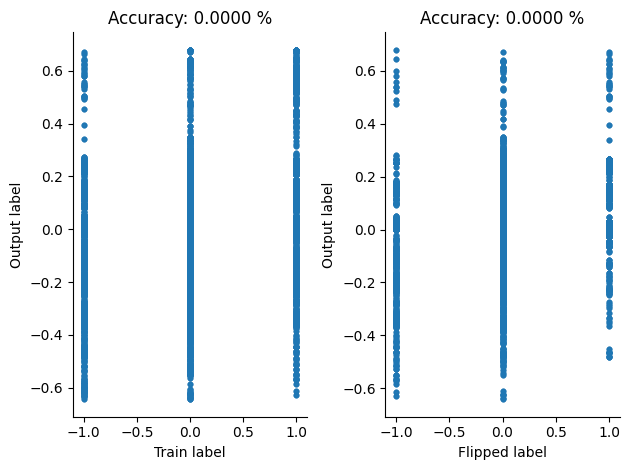

In [35]:
#@title Evaluating the accuracy of the model
with torch.no_grad():
  train_outputs = fixed_sign_net(train_data)
  flipped_outputs = fixed_sign_net(train_data[flip_idx,:])

  # Calculate accuracy
  train_accuracy = 100 * (torch.isclose(train_outputs.squeeze(), train_labels_flipped, rtol=1e-1)).sum() / train_labels.shape[0]
  flipped_accuracy = 100 * (torch.isclose(flipped_outputs.squeeze(), train_labels_flipped[flip_idx], rtol=1e-1)).sum() / test_labels.shape[0]

fig, axs = plt.subplots(1,2)

axs[0].scatter(train_labels.flatten().cpu().numpy(), train_outputs.flatten().cpu().numpy(), s=10,alpha=0.5)
axs[0].set_xlabel('Train label')
axs[0].set_ylabel('Output label')
axs[0].set_title('Accuracy: %.4f %%' %(train_accuracy))

axs[1].scatter(train_labels_flipped[flip_idx].flatten().cpu().numpy(), flipped_outputs.flatten().cpu().numpy(), s=10,alpha=0.5)
axs[1].set_xlabel('Flipped label')
axs[1].set_ylabel('Output label')
axs[1].set_title('Accuracy: %.4f %%' %(flipped_accuracy))

EP_to_LHb.weight
 Positive: 36.27333343029022%; Negative: 33.97666811943054%; Zero: 29.750001430511475%
EP_to_LHb.bias
 Positive: 43.00000071525574%; Negative: 40.00000059604645%; Zero: 17.000000178813934%
LHb_to_DAN.weight
 Positive: 0.0%; Negative: 7.000000029802322%; Zero: 93.00000071525574%
LHb_to_DAN.bias
 Positive: 50.0%; Negative: 0.0%; Zero: 50.0%


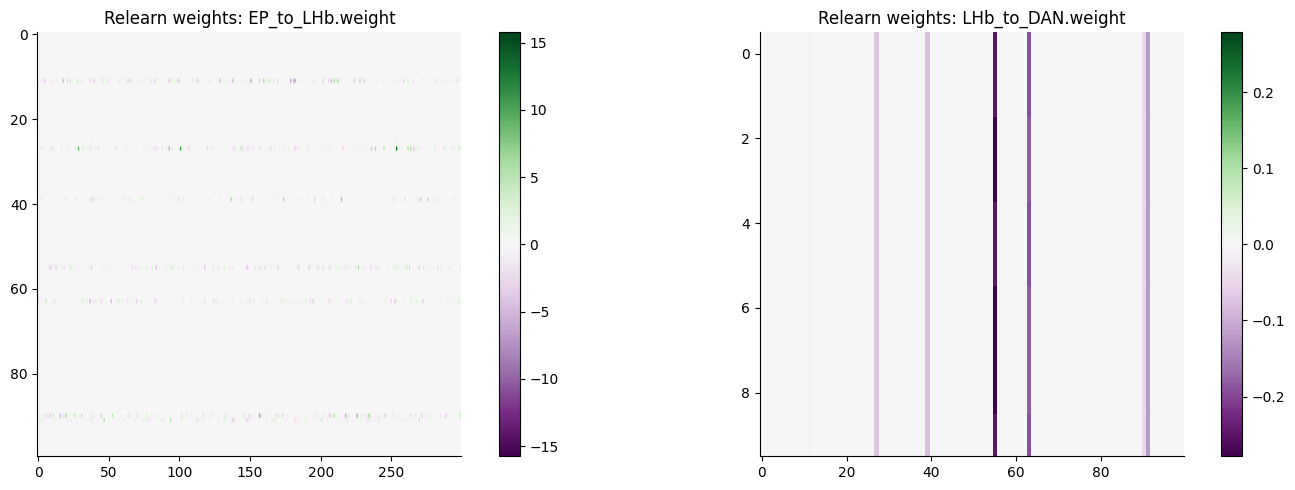

In [36]:
# Save the trianed parameters in paramList
relearn_params_fixed = fixed_sign_net.record_params()

# Plot initialized weights
fig, axs = plt.subplots(1,int(len(initial_params_fixed)/2),figsize=(15, 5))
plt.subplots_adjust(hspace=0.5)

ax = 0
for key, value in relearn_params_fixed.items():
    if "bias" in key: continue
    im = axs[ax].imshow(value.numpy(), cmap='PRGn', aspect=value.shape[1]/value.shape[0],
                        vmax=abs(value.numpy()).max(), vmin=-abs(value.numpy()).max())
    axs[ax].set_title('Relearn weights: ' + key)
    plt.colorbar(im)
    ax += 1

plt.tight_layout()
plt.show()

EP_to_LHb.weight flipped:  0.000% (0/30000)
EP_to_LHb.bias flipped:  0.000% (0/100)
LHb_to_DAN.weight flipped:  0.000% (0/1000)
LHb_to_DAN.bias flipped:  0.000% (0/10)
EP_to_LHb.weight changed:  30.600% (9180/30000)
EP_to_LHb.bias changed:  34.000% (34/100)
LHb_to_DAN.weight changed:  7.000% (70/1000)
LHb_to_DAN.bias changed:  50.000% (5/10)


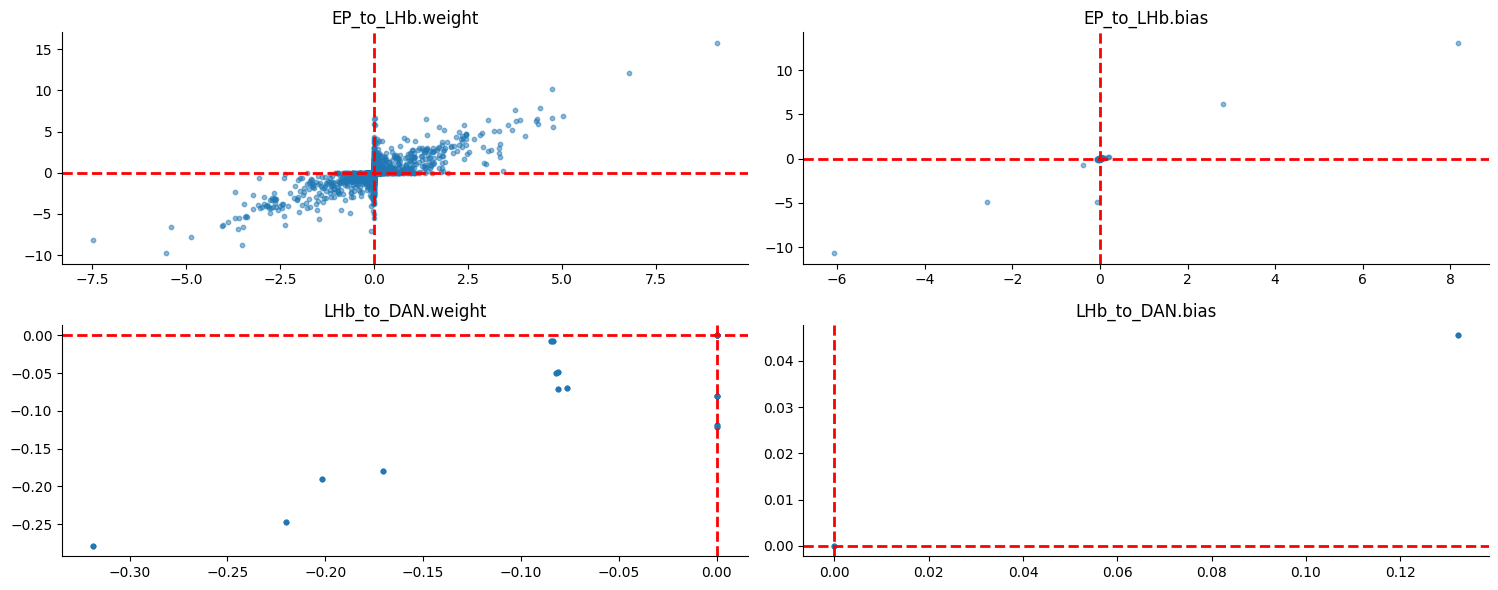

In [37]:
#@title What fraction of parameters flip sign?
for key in trained_params_fixed:
    n_weights=trained_params_fixed[key].numel()
    n_flip = (trained_params_fixed[key].sign()*relearn_params_fixed[key].sign()<0).count_nonzero().item()
    print(key + ' flipped: % .3f%% (%d/%d)' %(100*n_flip/n_weights, n_flip, n_weights))

for key in trained_params_fixed:
    n_weights=trained_params_fixed[key].numel()
    n_changed = (trained_params_fixed[key] != relearn_params_fixed[key]).count_nonzero().item()
    print(key + ' changed: % .3f%% (%d/%d)' %(100*n_changed/n_weights, n_changed, n_weights))


# Plot initial vs trained values
fig, axs = plt.subplots(2,int(len(relearn_params_fixed)/2),figsize=(15, 6))
plt.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axs.flatten()):
    key = list(relearn_params_fixed)[i]
    ax.scatter(trained_params_fixed[key].numpy(),relearn_params_fixed[key].numpy(),s=10,alpha=0.5)
    ax.axhline(y=0, linewidth=2, color = 'r', ls='--')
    ax.axvline(x=0, linewidth=2, color = 'r', ls='--')
    ax.set_title(key)

plt.tight_layout()
plt.show()

## Weight change analysis

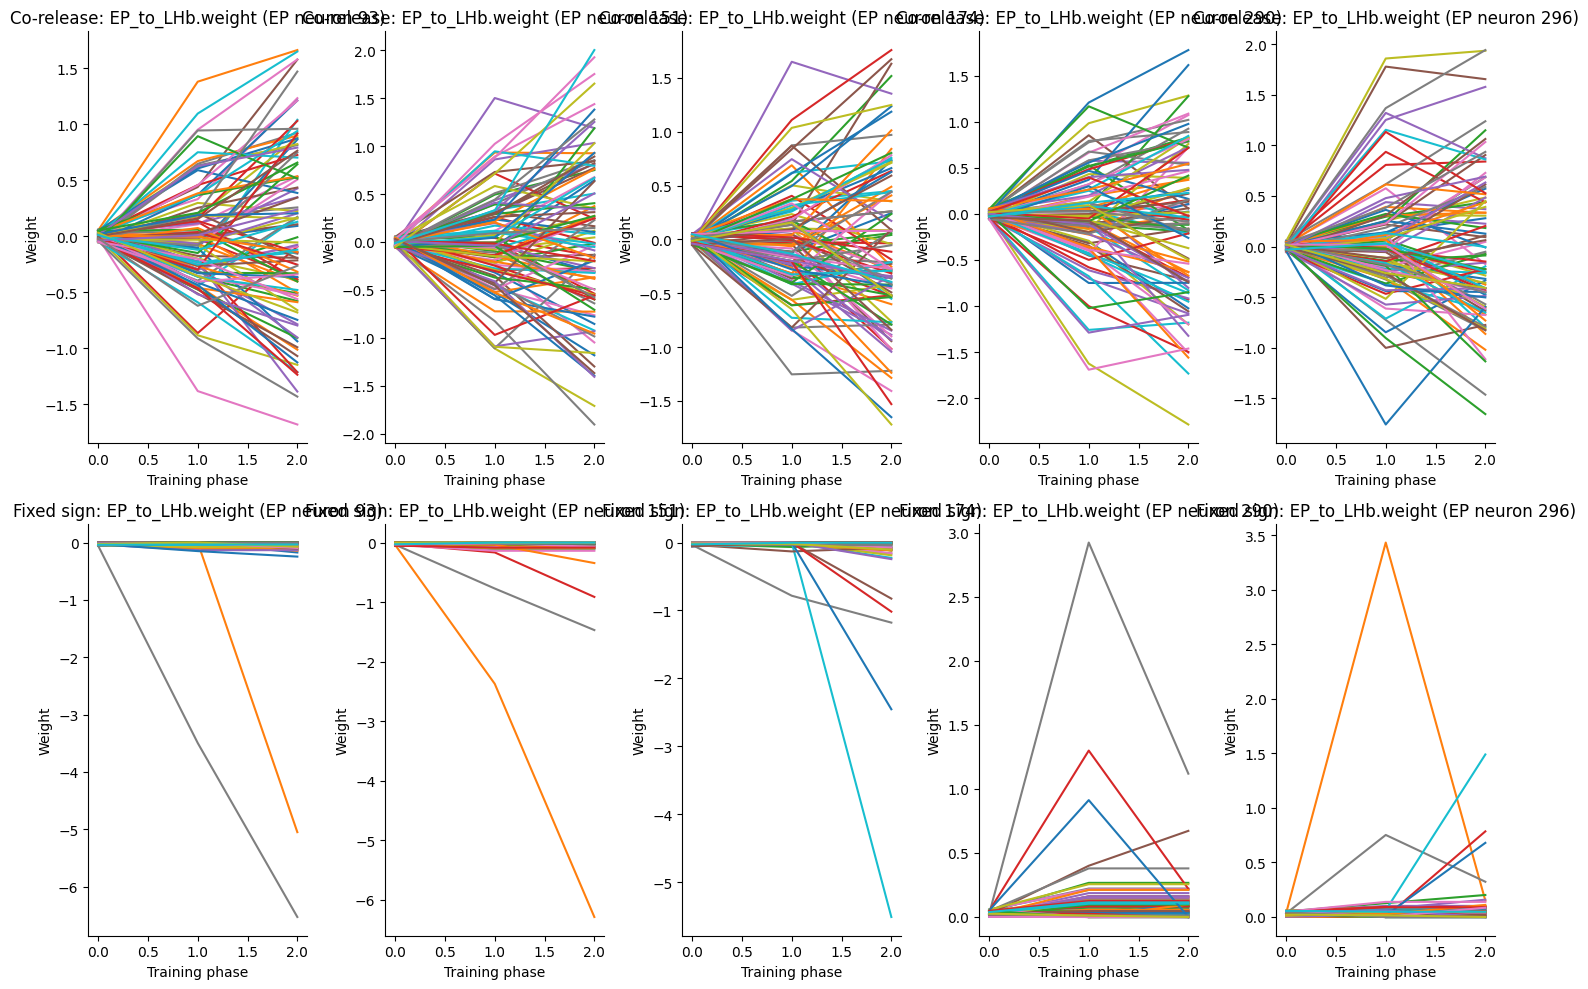

In [38]:
# Plot flipped EP neuron weight changes
n_row = 2
n_col = flip_EP.shape[0]

fig, axs = plt.subplots(n_row,n_col,figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

key = 'EP_to_LHb.weight'
for i, neuron in enumerate(flip_EP):
    weight_history_corelease = [initial_params_corelease[key][:,neuron].flatten(),
                                trained_params_corelease[key][:,neuron].flatten(),
                                relearn_params_corelease[key][:,neuron].flatten()]

    weight_history_fixed = [initial_params_fixed[key][:,neuron].flatten(),
                            trained_params_fixed[key][:,neuron].flatten(),
                            relearn_params_fixed[key][:,neuron].flatten()]

    axs.flatten()[i].plot(weight_history_corelease)
    axs.flatten()[i].set_xlabel('Training phase')
    axs.flatten()[i].set_ylabel('Weight')
    axs.flatten()[i].set_title('Co-release: %s (EP neuron %d)' %(key, neuron))
    axs.flatten()[i+n_col].plot(weight_history_fixed)
    axs.flatten()[i+n_col].set_xlabel('Training phase')
    axs.flatten()[i+n_col].set_ylabel('Weight')
    axs.flatten()[i+n_col].set_title('Fixed sign: %s (EP neuron %d)' %(key, neuron))

plt.tight_layout()
plt.show()

In [39]:
# # Plot overall weight changes
# n_row = 2
# n_col = len(relearn_params_corelease)

# fig, axs = plt.subplots(n_row,n_col,figsize=(15, 10))
# plt.subplots_adjust(hspace=0.5)

# for i, ax in enumerate(axs.flatten()):
#     if i >= len(list(initial_params_corelease)): break
#     key = list(initial_params_corelease)[i]
#     print(key)
#     weight_history_corelease = [initial_params_corelease[key].flatten(),
#                                 trained_params_corelease[key].flatten(),
#                                 relearn_params_corelease[key].flatten()]

#     weight_history_fixed = [initial_params_fixed[key].flatten(),
#                             trained_params_fixed[key].flatten(),
#                             relearn_params_fixed[key].flatten()]

#     axs.flatten()[i].plot(weight_history_corelease)
#     axs.flatten()[i].set_xlabel('Training phase')
#     axs.flatten()[i].set_ylabel('Weight')
#     axs.flatten()[i].set_title('Co-release: ' + key)
#     axs.flatten()[i+n_col].plot(weight_history_fixed)
#     axs.flatten()[i+n_col].set_xlabel('Training phase')
#     axs.flatten()[i+n_col].set_ylabel('Weight')
#     axs.flatten()[i+n_col].set_title('Fixed sign: ' + key)

# plt.tight_layout()
# plt.show()

## Train multiple networks per condition

Different initialization scenarios
- random initialization of every synapses
- Dale's law initialization of every synapses

Different network structure
- LHb to DAN is all inhibitory + LHb to LHb is all excitatory (if RNN)
- Every layer have mixed excitatory/inhibitory output

Different update methods
- Normal ADAM
- Fixed sign ADAM

In [40]:
EP_size = 300 # there are this many inputs that represent features and set to -1, 0, 1
LHB_size = 100 # number of neurons in the LHB that receive EP input
DAN_size = 1 # how DANs to calculate value
batch_size = 200 # the size of input data took for one iteration
num_epochs = 200
num_relearn_epochs = 200
lr = 1e-2 # size of step

label_type = 'digital' # or 'digital'
prob_EP_to_LHb = 1

n_networks = 20 # number of networks to train

In [41]:
#@title Generate the data

prob_input_active = 0.05 # probability that an input is active in each context
prob_output_active = 0.125
n_contexts = 5000

rands = torch.rand(n_contexts, EP_size, device=device)
train_data = 1.0*(rands<prob_input_active) - 1.0*(rands>(1-prob_input_active))
rands = torch.rand(n_contexts, device=device)
if label_type == 'analog': train_labels = 2*rands-1
else: train_labels = 1.0*(rands<prob_output_active) - 1.0*(rands>(1-prob_output_active))
# train_labels = torch.transpose(train_labels.repeat(DAN_size, 1), 0, 1)

train_dataset = NeuronalData(train_data,train_labels)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

Text(0.5, 1.0, 'Train labels')

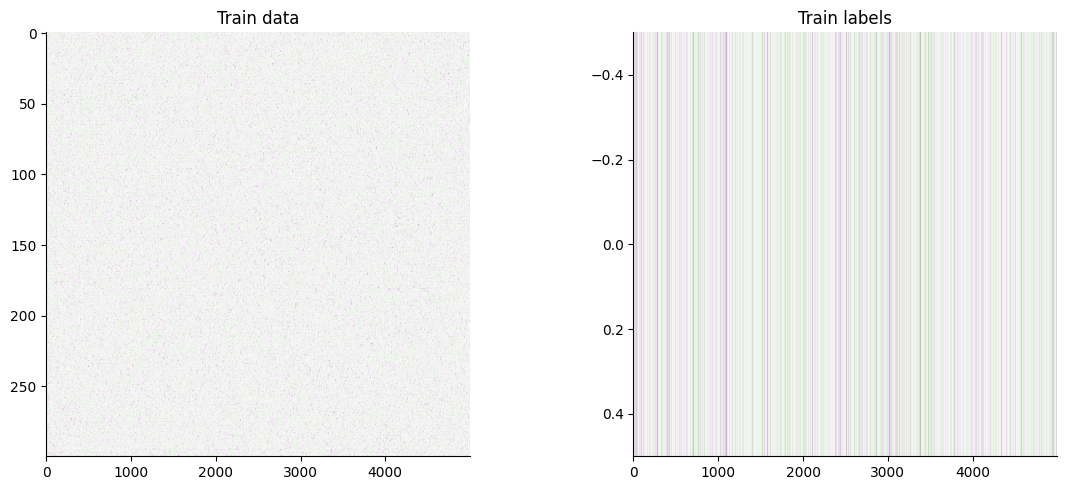

In [42]:
# Plot training data and label
fig, axs = plt.subplots(1,2, figsize=(15,5))
im = axs[0].imshow(torch.t(train_data), cmap='PRGn', aspect=train_data.shape[0]/train_data.shape[1])
axs[0].set_title('Train data')
im = axs[1].imshow(train_labels[None], cmap='PRGn', aspect=train_labels.shape[0])
axs[1].set_title('Train labels')

In [43]:
# Randomly select inputs, and flip corresponding labels
prob_EP_flip = 0.02

input_mask = torch.rand(EP_size,device=device) < prob_EP_flip
flip_EP = torch.linspace(1,EP_size,EP_size)[input_mask].to(torch.int32)
flip_idx = train_data.nonzero()[torch.isin(train_data.nonzero()[:,1], flip_EP),0].unique()

train_labels_flipped = train_labels.clone()
train_labels_flipped[flip_idx] *= -1

n_flip = (train_labels.sign()*train_labels_flipped.sign()<0).count_nonzero().item()
print('Flipped percentage: %.3f%%, %d/%d' % (100*n_flip/train_labels.shape[0], n_flip, n_contexts))
print('Flipped EP neurons: ' + str(flip_EP.numpy()))

flip_dataset = NeuronalData(train_data,train_labels_flipped)
flip_loader = DataLoader(dataset=flip_dataset, batch_size=batch_size, shuffle=True)

Flipped percentage: 11.060%, 553/5000
Flipped EP neurons: [ 16  64 116 133 154 269]


Text(0.5, 1.0, 'Flipped labels')

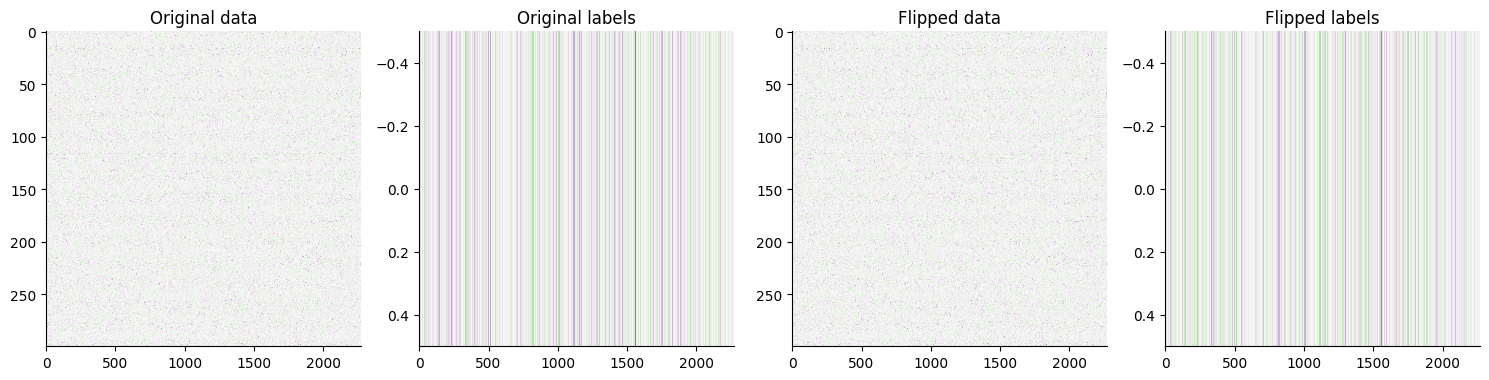

In [44]:
# Plot training data and label
fig, axs = plt.subplots(1,4, figsize=(15,5))

im = axs[0].imshow(torch.t(train_data[flip_idx]), cmap='PRGn', aspect=train_data[flip_idx].shape[0]/train_data[flip_idx].shape[1])
axs[0].set_title('Original data')

im = axs[1].imshow(train_labels[flip_idx][None], cmap='PRGn', aspect=train_labels[flip_idx].shape[0])
axs[1].set_title('Original labels')

im = axs[2].imshow(torch.t(train_data[flip_idx]), cmap='PRGn', aspect=train_data[flip_idx].shape[0]/train_data[flip_idx].shape[1])
axs[2].set_title('Flipped data')

im = axs[3].imshow(train_labels_flipped[flip_idx][None], cmap='PRGn', aspect=train_labels_flipped[flip_idx].shape[0])
axs[3].set_title('Flipped labels')

### Train multiple co-release models

In [45]:
cr_training_loss_summary = []

for i in range(1,n_networks+1):
    # Initialize a network
    net = EPLHb(EP_size,LHB_size,DAN_size,prob_EP_to_LHb,fixed_sign=False)
    initial_params = net.record_params(calc_sign=False)
    net_training_loss = []
    if torch.cuda.is_available(): net.cuda()

    # Train on original data
    optimizer = adam(net.parameters(), lr=lr, fixed_sign=False)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    training_loss = net.train_model(num_epochs,train_loader,optimizer,print_epoch=False)
    net_training_loss.extend(training_loss)

    # Train on flipped data
    optimizer = adam(net.parameters(), lr=lr, fixed_sign=False)
    training_loss = net.train_model(num_epochs,flip_loader,optimizer,print_epoch=False)
    net_training_loss.extend(training_loss)

    cr_training_loss_summary.append(net_training_loss)
    print('Finished training co-release network %d/%d' %(i,n_networks))

# Convert list to numpy array
cr_training_loss_summary = np.array(cr_training_loss_summary)

# # Plot training loss for all network separately
# fig, axs = plt.subplots(n_networks,1,figsize=(15,3*n_networks))
# for i, ax in enumerate(axs.flatten()):
#     ax.plot(cr_training_loss_summary[i])
#     ax.set_title('Corelease # %d' %(i+1))

Finished training co-release network 1/20
Finished training co-release network 2/20
Finished training co-release network 3/20
Finished training co-release network 4/20
Finished training co-release network 5/20
Finished training co-release network 6/20
Finished training co-release network 7/20
Finished training co-release network 8/20
Finished training co-release network 9/20
Finished training co-release network 10/20
Finished training co-release network 11/20
Finished training co-release network 12/20
Finished training co-release network 13/20
Finished training co-release network 14/20
Finished training co-release network 15/20
Finished training co-release network 16/20
Finished training co-release network 17/20
Finished training co-release network 18/20
Finished training co-release network 19/20
Finished training co-release network 20/20


### Train multiple fixed sign models

In [46]:
fs_training_loss_summary = []

for i in range(1,n_networks+1):
    # Initialize a network
    net = EPLHb(EP_size,LHB_size,DAN_size,prob_EP_to_LHb,fixed_sign=True)
    initial_params = net.record_params(calc_sign=False)
    net_training_loss = []
    if torch.cuda.is_available(): net.cuda()

    # Train on original data
    optimizer = adam(net.parameters(), lr=lr, fixed_sign=True)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    training_loss = net.train_model(num_epochs,train_loader,optimizer,print_epoch=False)
    net_training_loss.extend(training_loss)

    # Train on flipped data
    optimizer = adam(net.parameters(), lr=lr, fixed_sign=True)
    training_loss = net.train_model(num_epochs,flip_loader,optimizer,print_epoch=False)
    net_training_loss.extend(training_loss)

    fs_training_loss_summary.append(net_training_loss)
    print('Finished training fixed sign network %d/%d' %(i,n_networks))

# Convert list to numpy array
fs_training_loss_summary = np.array(fs_training_loss_summary)

# # Plot training loss for all network separately
# fig, axs = plt.subplots(n_networks,1,figsize=(15,3*n_networks))
# for i, ax in enumerate(axs.flatten()):
#     ax.plot(fs_training_loss_summary[i])
#     ax.set_title('Fixed # %d' %(i+1))

Finished training fixed sign network 1/20
Finished training fixed sign network 2/20
Finished training fixed sign network 3/20
Finished training fixed sign network 4/20
Finished training fixed sign network 5/20
Finished training fixed sign network 6/20
Finished training fixed sign network 7/20
Finished training fixed sign network 8/20
Finished training fixed sign network 9/20
Finished training fixed sign network 10/20
Finished training fixed sign network 11/20
Finished training fixed sign network 12/20
Finished training fixed sign network 13/20
Finished training fixed sign network 14/20
Finished training fixed sign network 15/20
Finished training fixed sign network 16/20
Finished training fixed sign network 17/20
Finished training fixed sign network 18/20
Finished training fixed sign network 19/20
Finished training fixed sign network 20/20


### Train fixed sign without negative output

In [47]:
fs_posneg_training_loss_summary = []

for i in range(1,n_networks+1):
    # Initialize a network
    net = EPLHb(EP_size,LHB_size,DAN_size,prob_EP_to_LHb,fixed_sign=True, neg_output=False)
    initial_params = net.record_params(calc_sign=False)
    net_training_loss = []
    if torch.cuda.is_available(): net.cuda()

    # Train on original data
    optimizer = adam(net.parameters(), lr=lr, fixed_sign=True)
    # scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    training_loss = net.train_model(num_epochs,train_loader,optimizer,print_epoch=False)
    net_training_loss.extend(training_loss)

    # Train on flipped data
    optimizer = adam(net.parameters(), lr=lr, fixed_sign=True)
    training_loss = net.train_model(num_epochs,flip_loader,optimizer,print_epoch=False)
    net_training_loss.extend(training_loss)

    fs_posneg_training_loss_summary.append(net_training_loss)
    print('Finished training fixed sign network %d/%d' %(i,n_networks))

# Convert list to numpy array
fs_posneg_training_loss_summary = np.array(fs_posneg_training_loss_summary)

# # Plot training loss for all network separately
# fig, axs = plt.subplots(n_networks,1,figsize=(15,3*n_networks))
# for i, ax in enumerate(axs.flatten()):
#     ax.plot(fs_training_loss_summary[i])
#     ax.set_title('Fixed # %d' %(i+1))

Finished training fixed sign network 1/20
Finished training fixed sign network 2/20
Finished training fixed sign network 3/20
Finished training fixed sign network 4/20
Finished training fixed sign network 5/20
Finished training fixed sign network 6/20
Finished training fixed sign network 7/20
Finished training fixed sign network 8/20
Finished training fixed sign network 9/20
Finished training fixed sign network 10/20
Finished training fixed sign network 11/20
Finished training fixed sign network 12/20
Finished training fixed sign network 13/20
Finished training fixed sign network 14/20
Finished training fixed sign network 15/20
Finished training fixed sign network 16/20
Finished training fixed sign network 17/20
Finished training fixed sign network 18/20
Finished training fixed sign network 19/20
Finished training fixed sign network 20/20


### Plot summary

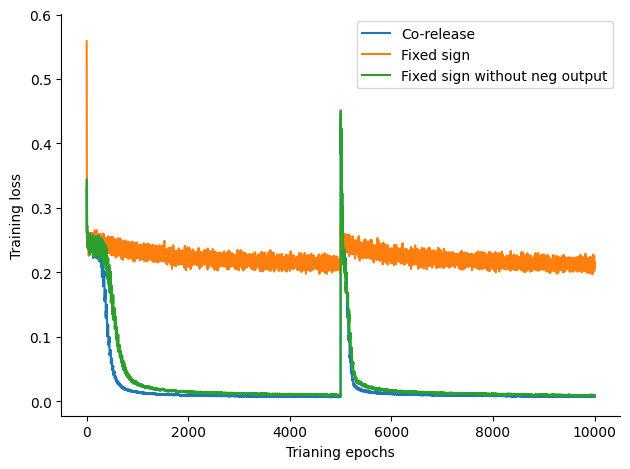

In [48]:
mean_cr_loss = np.mean(cr_training_loss_summary,axis=0)
sem_cr_loss = stats.sem(cr_training_loss_summary)
mean_fs_loss = np.mean(fs_training_loss_summary,axis=0)
sem_fs_loss = stats.sem(fs_training_loss_summary)
mean_fs_posneg_loss = np.mean(fs_posneg_training_loss_summary,axis=0)
sem_fs_posneg_loss = stats.sem(fs_posneg_training_loss_summary)

# Plot
x = np.linspace(1,mean_cr_loss.shape[0],num=mean_cr_loss.shape[0],dtype='int32')
plt.plot(mean_cr_loss, label='Co-release')
plt.fill_between(x,mean_cr_loss+sem_cr_loss,mean_cr_loss-sem_cr_loss,alpha=0.2)
plt.plot(mean_fs_loss, label='Fixed sign')
plt.fill_between(x,mean_fs_loss+sem_fs_loss,mean_fs_loss-sem_fs_loss,alpha=0.2)
plt.plot(mean_fs_posneg_loss, label='Fixed sign without neg output')
plt.fill_between(x,mean_fs_posneg_loss+sem_fs_posneg_loss,mean_fs_posneg_loss-sem_fs_posneg_loss,alpha=0.2)

plt.xlabel('Trianing epochs')
plt.ylabel('Training loss')
plt.legend()
plt.show()